In [4]:
%env PYTHONHASHSEED=0

env: PYTHONHASHSEED=0


In [79]:
import tensorflow as tf
import numpy as np
import time
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from collections import Counter
from matplotlib import pyplot

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

np.seterr(invalid='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [6]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# fix random seed for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
seed = 85497648
np.random.seed(seed)
random.seed(123)

NUM_PARALLEL_EXEC_UNITS = 4
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS, inter_op_parallelism_threads=2,
                              allow_soft_placement=True, device_count={'CPU': NUM_PARALLEL_EXEC_UNITS})

tf.random.set_seed(123)

sess = tf.compat.v1.Session(config=session_conf)

os.environ["OMP_NUM_THREADS"] = str(NUM_PARALLEL_EXEC_UNITS)
os.environ["KMP_BLOCKTIME"] = "30"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1,0"

## Dataset Loading

The dataset used contains 74,830 frequency records of events detected in the Brazilian Interconnected Power System (BIPS) over a 12-year period, including both historical event data and records obtained through the application of the event detection methodology. All records were then visually inspected, and each preliminary detection was manually classified as Class 0 if it was a false event, or Class 1 if it was a true systemic event. In this process, 8,853 detections were classified as Class 1 and 65,977 as Class 0. Subsequently, the dataset was divided into a training set consisting of 80\% of the detections randomly selected for each class, and a validation set containing the remaining 20\%

Nevertheless, due to confidentiality restrictions, the dataset cannot be shared publicly.

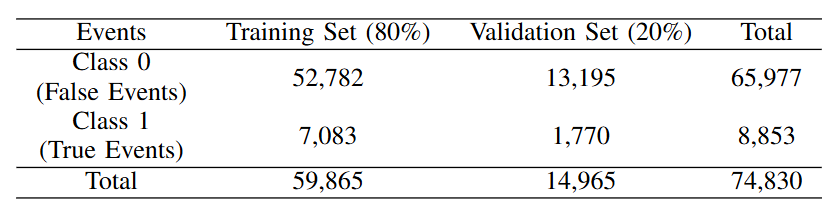





In [70]:
rlist = np.load('/content/drive/MyDrive/Dados_10_22/Train_Events_10_22_normalizado_class_seq_nova_sem_TN_22.npz', allow_pickle=True)

X_train = rlist['data']
Train_label = rlist['label']

Y_train = [int(i) for i in Train_label]

In [30]:
rlist = np.load('/content/drive/MyDrive/Dados_10_22/Val_Events_10_22_normalizado_class_seq_nova_sem_TN_22.npz', allow_pickle=True)
X_val = rlist['data']
Val_label = rlist['label']

Y_val = [int(i) for i in Val_label]
Y_val = tf.keras.utils.to_categorical(Y_val, num_classes=2)

## Database Balancing


Due to the excess of false events, which represent a quantity eight times greater than the number of true positives, balancing techniques were applied to the training database. The SMOTE technique was chosen to perform an oversampling of approximately 1.5\% in the true events class records. Meanwhile, to reduce the number of records in the false events class, the RandomUnderSampler technique, was used, randomly eliminating 35\% of these records. We chose not to make the database completely balanced. The main reason is to prevent the elimination of important false event samples and to prevent bias in the network due to the excessive increase of true event samples.

## RandomUnderSampler

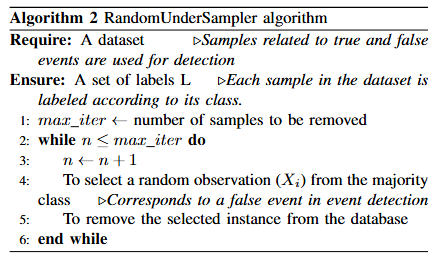

In [38]:
# # Resamples the data into a format compatible with the RandomUnderSampler function.
# X_train = np.reshape( X_train,(X_train.shape[0], 320*24))

# # Define undersample strategy
# undersample = RandomUnderSampler(sampling_strategy=0.3)
# # fit and apply the transform
# X_train, Y_train = undersample.fit_resample(X_train, Y_train)

## SMOTE

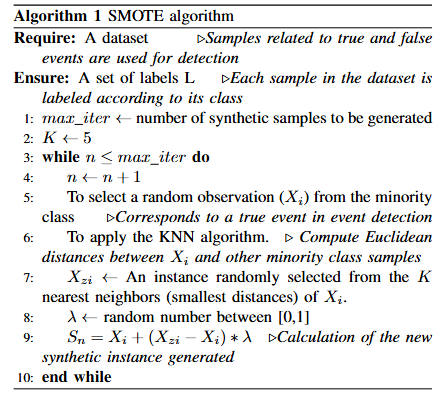

In [71]:
X_train = np.reshape(X_train,(X_train.shape[0], 320*24))

# Define SMOTE strategy
oversample = SMOTE(sampling_strategy=0.3)
X_train, Y_train = oversample.fit_resample(X_train, Y_train)

At the end of the data balancing process, the training set was adjusted and contains the following number of samples for each class, as shown below.

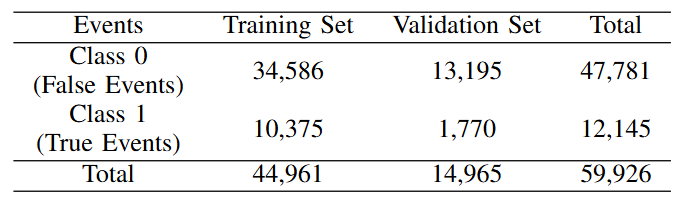

In [72]:
# Resampled the training set back to the original data format.
X_train = np.reshape(X_train,(X_train.shape[0], 320, 24))

# Reshaping the input data matrix to the channel-last format
number_rows, number_cols = X_train.shape[1], X_train.shape[2]
trainX_arr = X_train.reshape(X_train.shape[0], number_rows, number_cols, 1)

Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=2)

# Reshaping the input data matrix to the channel-last format
valX_arr = X_val.reshape(X_val.shape[0], number_rows, number_cols, 1)




## Example of an event record with normalized data

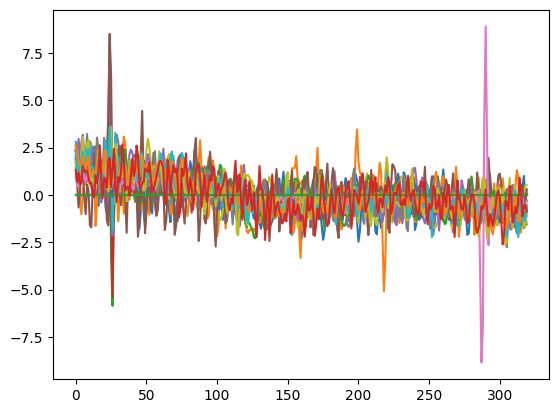

In [46]:
X = trainX_arr[10,:,:,0]

plt.plot(X)
plt.show()


## Function: create_model ()

The CNN architecture consists of three convolutional layers, each one with 256, 128, and 128 filters, respectively, all using rectified linear unit (ReLU) activation. Each convolutional layer is followed by batch normalization, max-pooling, and dropout layers with rates of 0.5, 0.5, and 0.8, respectively. In the classification stage, the resulting feature maps are flattened and passed through a fully connected layer with 100 neurons and ReLU activation, followed by batch normalization, a dropout layer (rate = 0.5), and an output layer with two neurons and a softmax activation function. Thus, the CNN produces a probability vector that validates or rejects the preliminary detection.

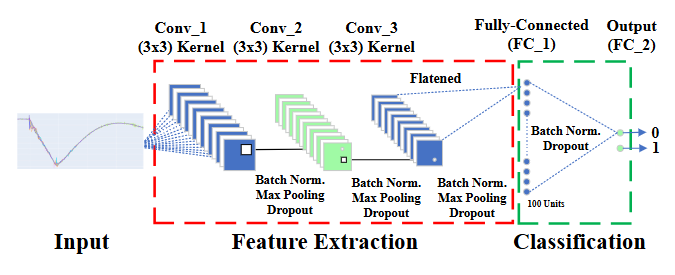



In [51]:
# Function to create model, required for KerasClassifier
input_shape = (number_rows, number_cols, 1)

def create_model():

    model = Sequential()
    model.add(Conv2D(256, kernel_size=(3, 3),
                     kernel_initializer=initializers.glorot_uniform(seed=66),
                     activation=tf.nn.relu,
                     input_shape=input_shape))
    model.add(BatchNormalization(momentum=0.55, scale=True, center=True))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.5, seed=66))

    model.add(Conv2D(128, kernel_size=(3, 3),
                     kernel_initializer=initializers.glorot_uniform(seed=66),
                     activation=tf.nn.relu))
    model.add(BatchNormalization(momentum=0.55, scale=True, center=True))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.5, seed=66))

    model.add(Conv2D(128, kernel_size=(3, 3),
                     kernel_initializer=initializers.glorot_uniform(seed=66),
                     activation=tf.nn.relu))
    model.add(BatchNormalization(momentum=0.55, scale=True, center=True))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.8, seed=66))

    model.add(Flatten())

    model.add(Dense(100,
                    kernel_initializer=initializers.glorot_uniform(seed=66),
                    activation=tf.nn.relu))
    model.add(BatchNormalization(momentum=0.55, scale=True, center=True))
    model.add(Dropout(0.5, seed=66))

    model.add(Dense(2,
                    kernel_initializer=initializers.glorot_uniform(seed=66),
                    activation=None))
    model.add(BatchNormalization(momentum=0.55, scale=True, center=True))
    model.add(Activation('softmax'))

    model.compile(loss='BinaryFocalCrossentropy',
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy(),
                           ],
                  weighted_metrics = [tf.keras.metrics.Recall(0.45)]
                  )


    return model

In [52]:
model = create_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 318, 22, 256)   │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 318, 22, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 159, 11, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 159, 11, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 157, 9, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 157, 9, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 79, 5, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 79, 5, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 77, 3, 128)     │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 77, 3, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 39, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 39, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9984)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       998,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           202 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 2)              │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,446,342 (5.52 MB)

 Trainable params: 1,445,114 (5.51 MB)

 Non-trainable params: 1,228 (4.80 KB)

## Model Training

The model will initially be trained for up to 50 epochs with a batch size of 32. In this case, training is carried out for all epochs, but the final model selected is the one that achieves the highest categorical accuracy on the validation set. This strategy ensures that, even if overfitting occurs during training, the model chosen will be the one with the best generalization capability.

In [53]:
import keras

time_start = time.time()

checkpoint_filepath = '/content/drive/MyDrive/checkpoint_model.keras'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

batch_size =32
history = model.fit(trainX_arr,Y_train, validation_data=(valX_arr, Y_val),  epochs=50, batch_size=batch_size, verbose=2, callbacks=[model_checkpoint_callback])
time_elapsed = (time.time() - time_start)

In [ ]:
# plot loss during training
size = 17
pyplot.subplot(211)
pyplot.rcParams['font.serif'] = "Times New Roman"
pyplot.rcParams['font.family'] = "serif"
plt.rcParams.update({'font.size': 16})
pyplot.title('Loss x Epochs', fontsize=size)
pyplot.plot(history.history['loss'], label='Training')
pyplot.plot(history.history['val_loss'], label='Validation')
pyplot.legend(fontsize= 13)
pyplot.xlabel("Epochs", fontsize= size)
pyplot.ylabel("Loss", fontsize= size)
# plot accuracy during training
pyplot.subplot(212)
pyplot.rcParams['font.serif'] = "Times New Roman"
pyplot.rcParams['font.family'] = "serif"
pyplot.title('Accuracy x Epochs', fontsize=size)
pyplot.plot(history.history['categorical_accuracy'], label='Training')
pyplot.plot(history.history['val_categorical_accuracy'], label='Validation')
pyplot.xlabel("Epochs", fontsize= size)
pyplot.ylabel("Accuracy",fontsize= size)
pyplot.legend(fontsize= 13)

plt.subplots_adjust(hspace=0.65)
pyplot.show()


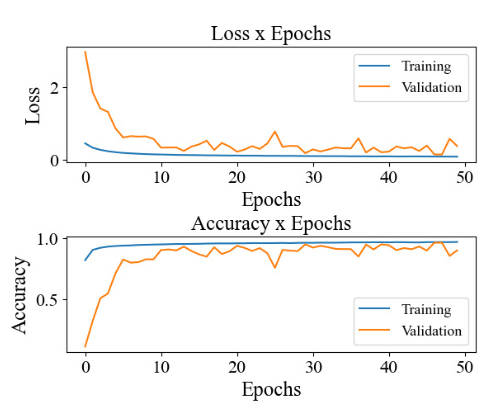

## Model performance metrics on the training dataset

In [76]:
print('Model performance metrics on the training dataset: ')
train_pred = model.predict(trainX_arr, batch_size=1)
train_pred = (train_pred > 0.5).astype(int)
train_acc = accuracy_score(Y_train, train_pred)
btrain_acc = balanced_accuracy_score(np.argmax(Y_train, axis=1), np.argmax(train_pred, axis=1))

print('0 1 ')
print(confusion_matrix(np.argmax(Y_train, axis=1), np.argmax(train_pred, axis=1)))
print('Train accuracy:', train_acc)
print('Train balanced accuracy:', btrain_acc)
print("Precision Score train : ",precision_score(Y_train, train_pred,
                                           average=None)[1])
print("recall Score train: ", recall_score(Y_train, train_pred,
                                           average=None)[1])

Model performance metrics on the training dataset: 
44961/44961 ━━━━━━━━━━━━━━━━━━━━ 403s 9ms/step
0 1 
[[33161  1425]
 [  273 10102]]
Train accuracy: 0.9622339360779342
Train balanced accuracy: 0.9662425523524736
Precision Score train :  0.8763772013533443
recall Score train:  0.9736867469879518


## Model performance metrics on the validation dataset

In [74]:
print('Model performance metrics on the validation dataset: ')
val_pred = model.predict(valX_arr, batch_size=1)
val_pred = (val_pred > 0.5).astype(int)
val_acc = accuracy_score(Y_val, val_pred)
bval_acc = balanced_accuracy_score(np.argmax(Y_val, axis=1), np.argmax(val_pred, axis=1))
bconfusion = confusion_matrix(np.argmax(Y_val, axis=1), np.argmax(val_pred, axis=1))

print('0 1')
print(bconfusion)
print('Val accuracy:', val_acc)
print('Val balanced accuracy:', bval_acc)
print("Precision Score val: ",precision_score(Y_val, val_pred,
                                           average=None)[1])
print("recall Score val: ", recall_score(Y_val, val_pred,
                                           average=None)[1])
print("AUC: ",roc_auc_score(Y_val, val_pred))
print("F1: ", f1_score(Y_val, val_pred, average='weighted'))

14965/14965 ━━━━━━━━━━━━━━━━━━━━ 136s 9ms/step
0 1
[[12607   588]
 [   72  1698]]
Val accuracy: 0.9558970932175075
Val balanced accuracy: 0.9573798498403991
Precision Score val:  0.7427821522309711
recall Score val:  0.9593220338983051
AUC:  0.9573798498403993
F1:  0.9582626879126321


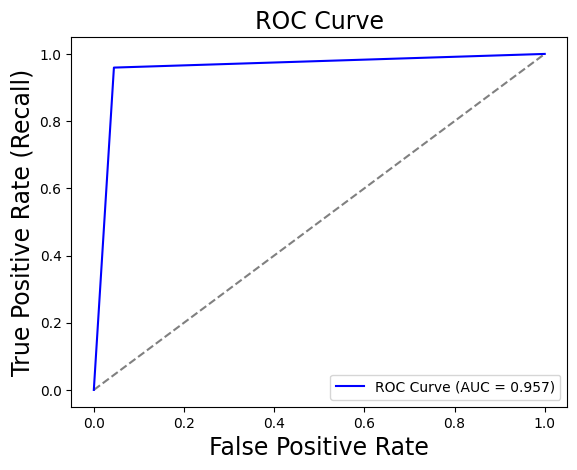

In [81]:
fpr, tpr, thresholds = roc_curve(np.argmax(Y_val, axis=1), np.argmax(val_pred, axis=1))
roc_auc = roc_auc_score(np.argmax(Y_val, axis=1), np.argmax(val_pred, axis=1))
size = 17
pyplot.figure()
pyplot.rcParams['font.serif'] = ['Times New Roman']
pyplot.title('ROC Curve', fontsize= size)
pyplot.plot([0, 1], [0, 1], color='gray', linestyle='--')
pyplot.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.3f})')
pyplot.ylabel('True Positive Rate (Recall)', fontsize= size)
pyplot.xlabel('False Positive Rate',fontsize= size)
pyplot.legend(fontsize= 13)
pyplot.legend(loc='lower right')
pyplot.show()

In [ ]:
# Saves the trained model weights for future use
model.save('/content/drive/MyDrive/CNN/CNN_3_camadas_10_22_recall_otimizado_smot_under_wm_seq_nova_VF.h5')